In [59]:
import numpy as np
import pandas as pd
import os
from pipe_bend_geometry.DefineBoundaryFittedGeometries import define_geometry
from pipe_bend_geometry.ShowMeshesForBoundaryFittedGeometries import show_mesh_for_boundary_fitted_geometries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import grad, functional
from PIL import Image
from channel_bend import gradient, get_normal_vectors
import torch.nn.init as init
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt




# Geometry

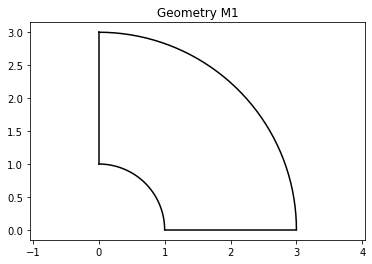

In [5]:
# Choose geometry
geometry = 'M1'
radius = 3
_ = define_geometry(geometry, radius, show_geometry=True)

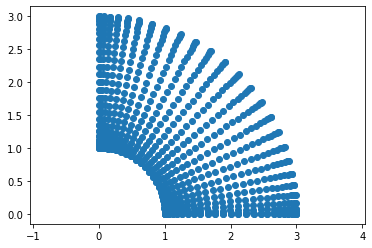

In [6]:
# Show the meshes/points for each geometry. 
physics_xs, physics_ys = show_mesh_for_boundary_fitted_geometries(geometry, radius, print_on_off=False, plot=False)
plt.scatter(physics_xs, physics_ys)
plt.axis('equal')
plt.show()

In [7]:
# Create array of all coordinates. 

physics_xys = np.zeros((physics_xs.shape[0], physics_xs.shape[1], 2))
for i in range(physics_xs.shape[0]):
    physics_xys[i] = np.column_stack((physics_xs[i], physics_ys[i]))

physics_xys = np.reshape(physics_xys, (physics_xs.shape[0]*physics_xs.shape[1], 2))

In [8]:
# Create inlet, outlet and walls arrays. 

# Define helper function
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll

inlet_xys = np.zeros((physics_xs[-1].shape[0], 2))
inlet_xys[:, 0] = physics_xs[-1]
inlet_xys[:, 1] = physics_ys[-1]
inlet_indices = find_sub_list(np.ndarray.tolist(inlet_xys), np.ndarray.tolist(physics_xys))

outlet_xys = np.zeros((physics_xs[0].shape[0], 2))
outlet_xys[:, 0] = physics_xs[0]
outlet_xys[:, 1] = physics_ys[0]
outlet_indices = find_sub_list(np.ndarray.tolist(outlet_xys), np.ndarray.tolist(physics_xys))

right_wall_xs = physics_xs[:, 0]
right_wall_ys = physics_ys[:, 0]

left_wall_xs = physics_xs[:, -1]
left_wall_ys = physics_ys[:, -1]

left_wall_xys = np.zeros((left_wall_xs.shape[0], 2))
left_wall_xys[:, 0] = left_wall_xs
left_wall_xys[:, 1] = left_wall_ys

right_wall_xys = np.zeros((right_wall_xs.shape[0], 2))
right_wall_xys[:, 0] = right_wall_xs
right_wall_xys[:, 1] = right_wall_ys

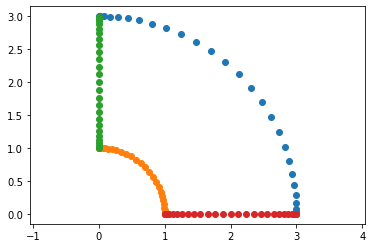

In [9]:
plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1])
plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1])
plt.scatter(inlet_xys[1:-1, 0], inlet_xys[1:-1, 1])
plt.scatter(outlet_xys[1:-1, 0], outlet_xys[1:-1, 1])
plt.axis('equal')
plt.show()

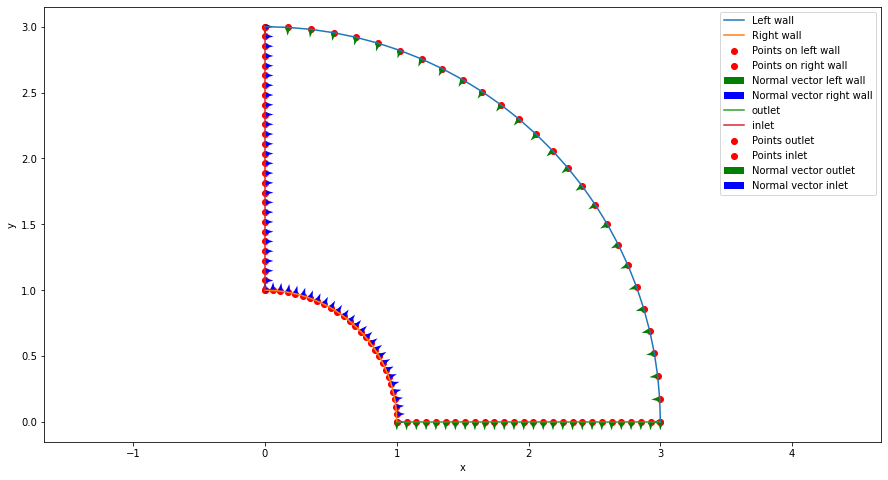

In [41]:
# Calculate normal vectors for the boundary condition, pipe walls.
gam1, _, gam2, _, gam3, _, gam4, _ = define_geometry(geometry, radius, show_geometry=False)

# Choose functions. This changes with choice of geometry (alas).
if geometry == 'M3':
    left_wall_fct = gam3
    right_wall_fct = gam1
    inlet_fct = gam4
    outlet_fct = gam2

if geometry == 'M1':
    left_wall_fct = gam2
    right_wall_fct = gam4
    inlet_fct = gam3
    outlet_fct = gam1

(
    normal_vectors_left,
    normal_vectors_right,
    normal_vectors_inlet,
    normal_vectors_outlet,
) = get_normal_vectors(
    left_wall_fct, right_wall_fct, inlet_fct, outlet_fct, nr_pts=28, show_normals=True
)

# Data

In [23]:
dir = os.getcwd()

data_u = pd.read_csv(os.path.join(dir,'data/Uvalues channel bend M1.csv'), header=None )
data_v = pd.read_csv(os.path.join(dir,'data/Vvalues channel bend M1.csv'), header=None )
data_xys = pd.read_csv(os.path.join(dir,'data/XYvalues channel bend coordinates.csv'), header=None)

In [24]:
exact_vel_u = data_u.to_numpy()
exact_vel_v = data_v.to_numpy()

In [25]:
arr_xys = data_xys.to_numpy()

In [26]:
data_xs = arr_xys[:, :28]
data_ys = arr_xys[:, 28:]

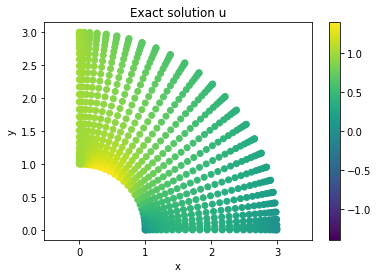

In [28]:
scatter = plt.scatter(data_xs, data_ys, c=exact_vel_u, vmin=-1.4, vmax=1.4)
colorbar = plt.colorbar(scatter)
plt.title(f"Exact solution u")
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')

# file = "plots/channel_exact_u.png"
# plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

plt.show()

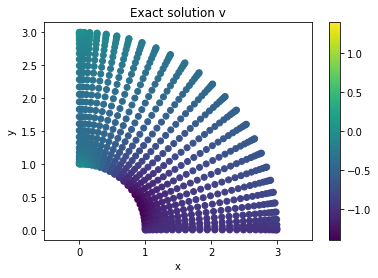

In [29]:
scatter = plt.scatter(data_xs, data_ys, c=exact_vel_v, vmin=-1.4, vmax=1.4)
colorbar = plt.colorbar(scatter)
plt.title(f"Exact solution v")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# file = "plots/channel_exact_v.png"
# plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

plt.show()

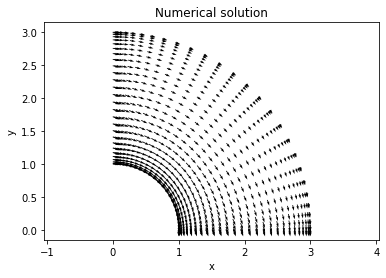

In [30]:
plt.title(f"Numerical solution")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.quiver(data_xs, data_ys, exact_vel_u, exact_vel_v)

# file = "plots/channel_exact_quiver.png"
# plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

plt.show()

# Neural Network

In [31]:
# Define network architecture.

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


In [32]:
# Move all to GPU if available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [49]:
# Define training loop and return loss_list 
# Include training data when available or just use physics loss. 
def train_pinn(model, 
        device,
        use_data, 
        learning_rate, 
        number_of_steps,
        save_plots, 
        exact_vel_u, 
        exact_vel_v, 
        physics_xys,
        inlet_indices,
        outlet_indices,
        right_wall_xys, 
        left_wall_xys, 
        normal_vectors_left, 
        normal_vectors_right
    ):

    # Define same "random" initialization og weights. 
    torch.manual_seed(123)
    
    # Data for M1 geoemtry
    exact_vel_u_inlet = torch.tensor(exact_vel_u[-1], dtype=torch.float32).to(device)
    exact_vel_v_inlet = torch.tensor(exact_vel_v[-1], dtype=torch.float32).to(device)
    exact_vel_u_outlet = torch.tensor(exact_vel_u[0], dtype=torch.float32).to(device)
    exact_vel_v_outlet = torch.tensor(exact_vel_v[0], dtype=torch.float32).to(device)
    
    
    # Define loss weighting. 
    pde_weight = 1e-2
    boundary_weight = 1.0
    data_weight = 1.0
    
    # Convert everything to tensors. 
    physics_xys_tensor = torch.tensor(physics_xys, dtype=torch.float32).requires_grad_(True).to(device)
    right_wall_xys_tensor = torch.tensor(right_wall_xys, dtype=torch.float32).requires_grad_(True).to(device)
    left_wall_xys_tensor = torch.tensor(left_wall_xys, dtype=torch.float32).requires_grad_(True).to(device)
    normal_vectors_left_tensor = torch.tensor(normal_vectors_left, dtype=torch.float32).to(device)
    normal_vectors_right_tensor = torch.tensor(normal_vectors_right, dtype=torch.float32).to(device)  
    
    # Define model.
    model = model.to(device)
    optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = StepLR(optimizer2, step_size=10000, gamma=0.95)
    
    loss_list = []
    
    # SoftAdapt.
    softadapt_object = SoftAdapt(beta=1)
    boundary_loss_list = []
    pde_loss_list = []
    data_loss_list = []
    adapt_weights = torch.tensor([boundary_weight, pde_weight, data_weight]).to(device)
    
    
    for i in range(number_of_steps + 1):
        optimizer2.zero_grad()
        
        # get model's results.
        physics_pred_fs = model(physics_xys_tensor)
        grad_f = gradient(physics_pred_fs, physics_xys_tensor)
        
        df_dx = grad_f[:, 0]
        df_dy = grad_f[:, 1]
        
        # Data loss
        if use_data:
            exact_df_dx = torch.tensor(exact_vel_u.flatten(), dtype=torch.float32).to(device)
            exact_df_dy = torch.tensor(exact_vel_v.flatten(), dtype=torch.float32).to(device)
            data_loss = torch.mean((df_dx - exact_df_dx)**2) + torch.mean((df_dy - exact_df_dy)**2)
        else:
            data_loss = 0
        
        # Physics loss
        d2f_dx2 = gradient(df_dx, physics_xys_tensor)[:, 0]
        d2f_dy2 = gradient(df_dy, physics_xys_tensor)[:, 1]
        
        # Define PDE residual. 
        residual_laplace = (d2f_dx2 + d2f_dy2)**2
        pde_residual_loss = torch.mean(residual_laplace)
        
        # Inlet loss
        inlet_grad_values = grad_f[inlet_indices[0]:inlet_indices[1], :]
        
        df_dx_inlet = inlet_grad_values[:, 0]
        df_dy_inlet = inlet_grad_values[:, 1]
        
        inlet_loss = torch.mean((df_dx_inlet - exact_vel_u_inlet)**2) + torch.mean((df_dy_inlet - exact_vel_v_inlet)**2)
        
        # Outlet loss
        outlet_grad_values = grad_f[outlet_indices[0]:outlet_indices[1], :]
        
        df_dx_outlet = outlet_grad_values[:, 0]
        df_dy_outlet = outlet_grad_values[:, 1]
        
        outlet_loss = torch.mean((df_dx_outlet - exact_vel_u_outlet)**2) + torch.mean((df_dy_outlet - exact_vel_v_outlet)**2)
        
        # Boundary condition on walls. Use zero-flux. 
        right_wall_values = model(right_wall_xys_tensor)
        left_wall_values = model(left_wall_xys_tensor)
        
        right_wall_grad = grad_f[::28, :]
        left_wall_grad = grad_f[27::28, :]
        
        flux_left_wall = left_wall_grad[:, 0] * normal_vectors_left_tensor[:, 0] + left_wall_grad[:, 1] * normal_vectors_left_tensor[:, 1]
        flux_right_wall = right_wall_grad[:, 0]  * normal_vectors_right_tensor[:, 0] + right_wall_grad[:, 1] * normal_vectors_right_tensor[:, 1]
        
        left_wall_loss = torch.mean(flux_left_wall**2)
        right_wall_loss = torch.mean(flux_right_wall**2)
        
        # Compute total boundary loss.
        boundary_loss = inlet_loss + outlet_loss + left_wall_loss + right_wall_loss 
        
        # Compute total physics loss.
        physics_loss = pde_residual_loss
        
        # SoftAdapt. Keep track of each loss component
        boundary_loss_list.append(boundary_loss)
        pde_loss_list.append(pde_residual_loss)
        data_loss_list.append(data_loss)
        
        # SoftAdapt. Update weights for every fifth step
        if i % 5 == 0 and i != 0:
            adapt_weights = softadapt_object.get_component_weights(
            torch.tensor(boundary_loss_list),
            torch.tensor(pde_loss_list),
            torch.tensor(data_loss_list),
            verbose=False,
            )
        
            boundary_loss_list = []
            pde_loss_list = []
            data_loss_list = []
        
        loss =  adapt_weights[0] * boundary_loss + adapt_weights[1] * physics_loss + adapt_weights[2] * data_loss 
        
        loss_list.append(loss)
        
        loss.backward()
        optimizer2.step()
        scheduler.step()
        
        
        # Visualize.
        if i % 5000 == 0 and i != 0:
            print(f'Step: {i}')
            print(f'PDE loss, boundary loss, data loss: {pde_residual_loss, boundary_loss, data_loss}')
        
            # Show PINNs values. 
            # Detach PIIns values. 
            values_dx = df_dx.cpu().detach().numpy()
            diff_dx = values_dx - exact_vel_u.flatten()
            values_dy = df_dy.cpu().detach().numpy()
            diff_dy = values_dy - exact_vel_v.flatten()
            values_laplace = residual_laplace.cpu().detach().numpy()
        
            # Plots
            scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1], c=diff_dx, vmin=-0.2, vmax=0.2)
            colorbar = plt.colorbar(scatter)
            plt.title(f"PINN u error at step {i}")
            plt.xlabel('x')
            plt.ylabel('y')
            plt.axis('equal')
            
            if save_plots and i % number_of_steps == 0:
                file = "plots/channel_pred_u_wd.png"
                plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            
            plt.show()
            
            scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1], c=diff_dy, vmin=-0.2, vmax=0.2)
            colorbar = plt.colorbar(scatter)
            plt.title(f"PINN v error at step {i}")
            plt.xlabel('x')
            plt.ylabel('y')
            plt.axis('equal')
        
            if save_plots and i % number_of_steps == 0:
                file = "plots/channel_pred_v_wd.png"
                plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
                
            plt.show()
        
            scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1], c=values_laplace, cmap='RdYlBu_r', edgecolors='k', linewidths=0.5, vmin=0.0, vmax=0.02)
            plt.colorbar(scatter)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.axis('equal')
            plt.title('Magnitude of Laplace residual')
        
            if save_plots and i % number_of_steps == 0:
                file = "plots/channel_pred_laplace_wd.png"
                plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            
            plt.show()

            # Return loss
            if i % number_of_steps == 0:
                return loss_list

In [48]:
# Shared parameters
number_of_steps = 5000
learning_rate = 1e-3
model = FullyConnected(2, 64, 1)
save_plots = False

Step: 5000
PDE loss, boundary loss, data loss: (tensor(0.0021, grad_fn=<MeanBackward0>), tensor(0.0115, grad_fn=<AddBackward0>), 0)


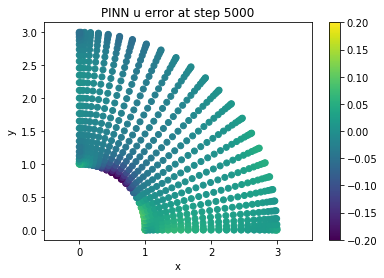

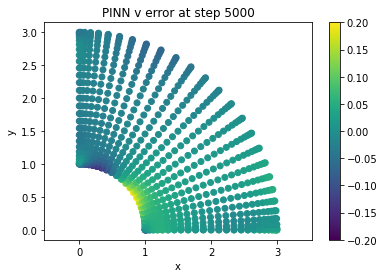

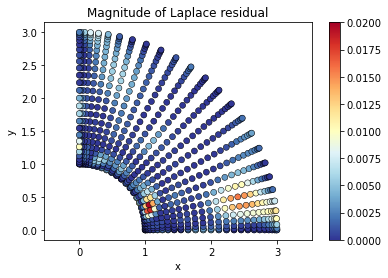

In [51]:
# Train without data
use_data = False
loss = train_pinn(model, device, use_data, learning_rate, number_of_steps, save_plots, exact_vel_u, exact_vel_v, physics_xys, inlet_indices, outlet_indices, right_wall_xys, left_wall_xys, normal_vectors_left, normal_vectors_right)

Step: 5000
PDE loss, boundary loss, data loss: (tensor(0.0018, grad_fn=<MeanBackward0>), tensor(0.0116, grad_fn=<AddBackward0>), tensor(0.0027, grad_fn=<AddBackward0>))


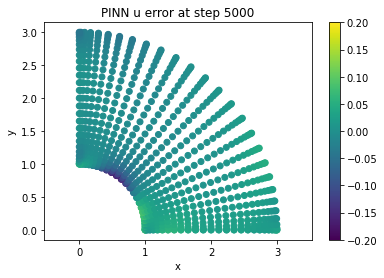

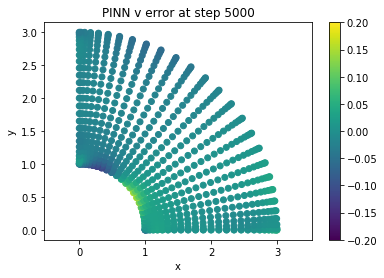

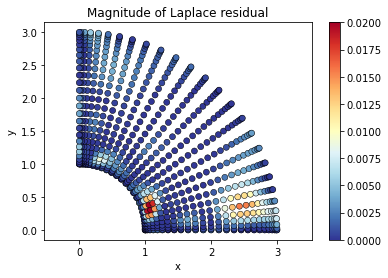

In [53]:
# Train with data
use_data = True
loss_with_data = train_pinn(model, device, use_data, learning_rate, number_of_steps, save_plots, exact_vel_u, exact_vel_v, physics_xys, inlet_indices, outlet_indices, right_wall_xys, left_wall_xys, normal_vectors_left, normal_vectors_right)

### Print Losses

In [54]:
loss_list_detached = []
for tensor in loss:
    loss_list_detached.append(tensor.cpu().detach())

In [55]:
loss_list_detached_with_data = []
for tensor in loss_with_data:
    loss_list_detached_with_data.append(tensor.cpu().detach())

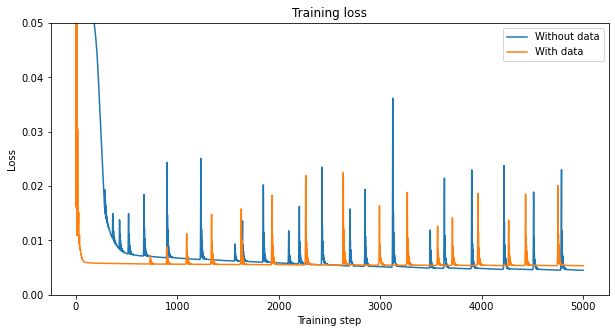

In [57]:
# Print full loss
plt.figure(figsize=(10,5))
plt.plot(loss_list_detached, label = 'Without data')
plt.plot(loss_list_detached_with_data, label = 'With data')
plt.title('Training loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.ylim((0.0,0.05))
plt.legend()

if save_plots:
    file = "plots/channel_loss.png"
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

plt.show()

In [ ]:
# Print loss for last 5000 steps
plt.figure(figsize=(10,5))
plt.plot(loss_list_detached, label = 'Without data')
plt.plot(loss_list_detached_with_data, label = 'With data')
plt.title('Training loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.ylim((0.0,0.02))
plt.xlim((number_of_steps - 5000,number_of_steps + 300))
plt.legend()

file = "plots/channel_loss_end.png"
plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

plt.show()